In [1]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.8 MB/s eta 0:00:00


In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
# import tensorflow as tf
from PIL import Image
import IPython.display as display
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline

## U2NET Model

In [3]:
import torch.nn as nn


class REBNCONV(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, dirate=1):
        super(REBNCONV, self).__init__()

        self.conv_s1 = nn.Conv2d(
            in_ch, out_ch, 3, padding=1 * dirate, dilation=1 * dirate
        )
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self, x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout


## upsample tensor 'src' to have the same spatial size with tensor 'tar'
def _upsample_like(src, tar):

    src = F.upsample(src, size=tar.shape[2:], mode="bilinear")

    return src


### RSU-7 ###
class RSU7(nn.Module):  # UNet07DRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)

        hx6 = self.rebnconv6(hx)

        hx7 = self.rebnconv7(hx6)

        hx6d = self.rebnconv6d(torch.cat((hx7, hx6), 1))
        hx6dup = _upsample_like(hx6d, hx5)

        hx5d = self.rebnconv5d(torch.cat((hx6dup, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        """
        del hx1, hx2, hx3, hx4, hx5, hx6, hx7
        del hx6d, hx5d, hx3d, hx2d
        del hx2dup, hx3dup, hx4dup, hx5dup, hx6dup
        """

        return hx1d + hxin


### RSU-6 ###
class RSU6(nn.Module):  # UNet06DRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)

        hx5d = self.rebnconv5d(torch.cat((hx6, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        """
        del hx1, hx2, hx3, hx4, hx5, hx6
        del hx5d, hx4d, hx3d, hx2d
        del hx2dup, hx3dup, hx4dup, hx5dup
        """

        return hx1d + hxin


### RSU-5 ###
class RSU5(nn.Module):  # UNet05DRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)

        hx5 = self.rebnconv5(hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        """
        del hx1, hx2, hx3, hx4, hx5
        del hx4d, hx3d, hx2d
        del hx2dup, hx3dup, hx4dup
        """

        return hx1d + hxin


### RSU-4 ###
class RSU4(nn.Module):  # UNet04DRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        """
        del hx1, hx2, hx3, hx4
        del hx3d, hx2d
        del hx2dup, hx3dup
        """

        return hx1d + hxin


### RSU-4F ###
class RSU4F(nn.Module):  # UNet04FRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4, hx3), 1))
        hx2d = self.rebnconv2d(torch.cat((hx3d, hx2), 1))
        hx1d = self.rebnconv1d(torch.cat((hx2d, hx1), 1))

        """
        del hx1, hx2, hx3, hx4
        del hx3d, hx2d
        """

        return hx1d + hxin


##### U^2-Net ####
class U2NET(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super(U2NET, self).__init__()

        self.stage1 = RSU7(in_ch, 32, 64)
        self.pool12 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage2 = RSU6(64, 32, 128)
        self.pool23 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage3 = RSU5(128, 64, 256)
        self.pool34 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage4 = RSU4(256, 128, 512)
        self.pool45 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage5 = RSU4F(512, 256, 512)
        self.pool56 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage6 = RSU4F(512, 256, 512)

        # decoder
        self.stage5d = RSU4F(1024, 256, 512)
        self.stage4d = RSU4(1024, 128, 256)
        self.stage3d = RSU5(512, 64, 128)
        self.stage2d = RSU6(256, 32, 64)
        self.stage1d = RSU7(128, 16, 64)

        self.side1 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side2 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side3 = nn.Conv2d(128, out_ch, 3, padding=1)
        self.side4 = nn.Conv2d(256, out_ch, 3, padding=1)
        self.side5 = nn.Conv2d(512, out_ch, 3, padding=1)
        self.side6 = nn.Conv2d(512, out_ch, 3, padding=1)

        self.outconv = nn.Conv2d(6 * out_ch, out_ch, 1)

    def forward(self, x):

        hx = x

        # stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        # stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        # stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        # stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        # stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        # stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6, hx5)

        # -------------------- decoder --------------------
        hx5d = self.stage5d(torch.cat((hx6up, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.stage4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.stage3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.stage2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.stage1d(torch.cat((hx2dup, hx1), 1))

        # side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2, d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3, d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4, d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5, d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6, d1)

        d0 = self.outconv(torch.cat((d1, d2, d3, d4, d5, d6), 1))

        """
        del hx1, hx2, hx3, hx4, hx5, hx6
        del hx5d, hx4d, hx3d, hx2d, hx1d
        del hx6up, hx5dup, hx4dup, hx3dup, hx2dup
        """

        return d0, d1, d2, d3, d4, d5, d6


### U^2-Net small ###
class U2NETP(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super(U2NETP, self).__init__()

        self.stage1 = RSU7(in_ch, 16, 64)
        self.pool12 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage2 = RSU6(64, 16, 64)
        self.pool23 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage3 = RSU5(64, 16, 64)
        self.pool34 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage4 = RSU4(64, 16, 64)
        self.pool45 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage5 = RSU4F(64, 16, 64)
        self.pool56 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage6 = RSU4F(64, 16, 64)

        # decoder
        self.stage5d = RSU4F(128, 16, 64)
        self.stage4d = RSU4(128, 16, 64)
        self.stage3d = RSU5(128, 16, 64)
        self.stage2d = RSU6(128, 16, 64)
        self.stage1d = RSU7(128, 16, 64)

        self.side1 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side2 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side3 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side4 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side5 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side6 = nn.Conv2d(64, out_ch, 3, padding=1)

        self.outconv = nn.Conv2d(6 * out_ch, out_ch, 1)

    def forward(self, x):

        hx = x

        # stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        # stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        # stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        # stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        # stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        # stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6, hx5)

        # decoder
        hx5d = self.stage5d(torch.cat((hx6up, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.stage4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.stage3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.stage2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.stage1d(torch.cat((hx2dup, hx1), 1))

        # side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2, d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3, d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4, d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5, d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6, d1)

        d0 = self.outconv(torch.cat((d1, d2, d3, d4, d5, d6), 1))

        """
        del hx1, hx2, hx3, hx4, hx5, hx6
        del hx5d, hx4d, hx3d, hx2d, hx1d
        del hx6up, hx5dup, hx4dup, hx3dup, hx2dup
        """

        return d0, d1, d2, d3, d4, d5, d6


## Text-to-Style

In [4]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')


In [5]:
#stable diffusion
pipe_stablediff = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe_stablediff = pipe_stablediff.to("cuda")
generator = torch.Generator("cuda").manual_seed(1112)


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

text_encoder/pytorch_model.fp16.safetensors not found


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.non_ema.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

(…)fusion_pytorch_model.non_ema.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:01<?, ?B/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

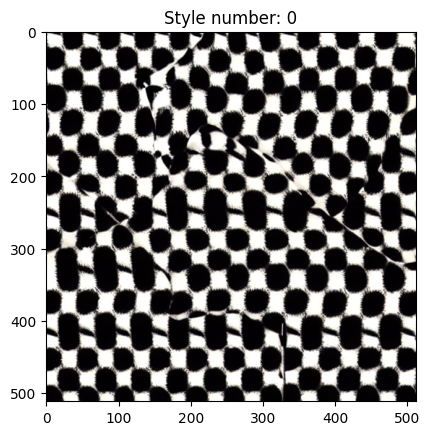

  0%|          | 0/50 [00:00<?, ?it/s]

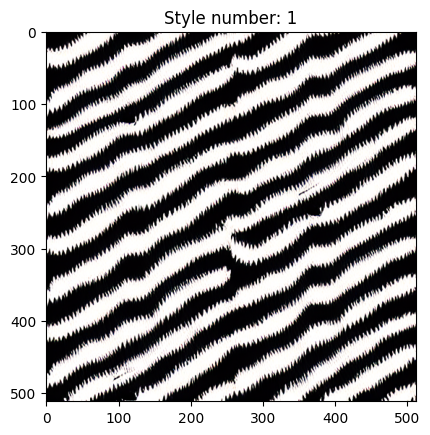

  0%|          | 0/50 [00:00<?, ?it/s]

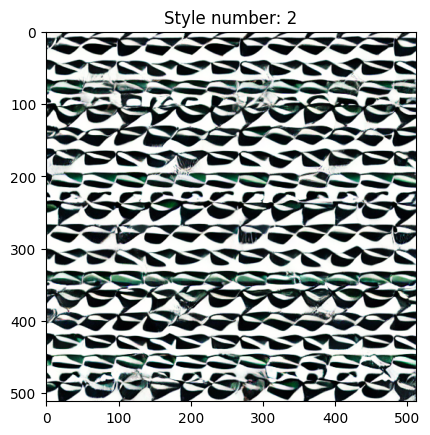

  0%|          | 0/50 [00:00<?, ?it/s]

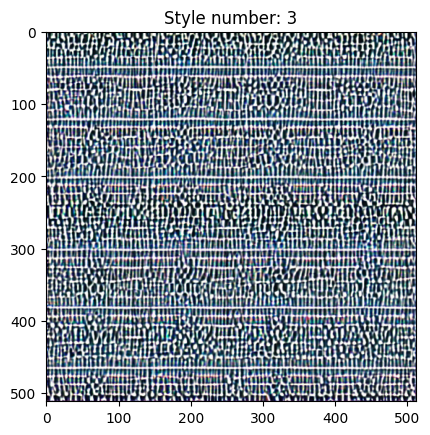

  0%|          | 0/50 [00:00<?, ?it/s]

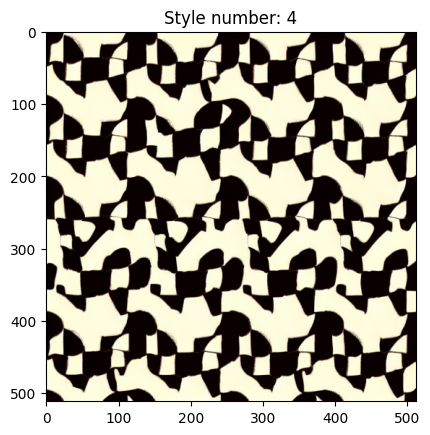

In [79]:
prompt = "Jackson Pollock painting pattern"# "newspaper print" #"abstract brushstroke flowers"#"tiny pastel cherry print pattern"#"alien toile"#"mid-century modern painting pattern"#"Hawaian Beach shirt print"#"crochet squares" "colourful abstract geometric pattern"mid-century modern pattern
style_images = []
for i in range(5):
    generator = torch.Generator("cuda").manual_seed(1000+4*i)
    style_image = pipe_stablediff(prompt, generator=generator).images[0]
    style_images.append(style_image)
    plt.imshow(style_image)
    plt.title(f'Style number: {i}')
    plt.show()

In [ ]:
style_num = 3
image_pil = Image.fromarray(np.array(style_images[style_num]))

# Save the image as a JPEG file
image_pil.save("/content/style.jpg")

# del style_images

In [80]:
torch.cuda.empty_cache()
del style_images

In [9]:
import tensorflow as tf

In [ ]:
from google.colab import files
uploaded = files.upload()

In [11]:
import os

In [12]:
original_file_name = list(uploaded.keys())[0]

# Specify the new file name
new_file_name = "content.jpg"

# Rename the file
os.rename(original_file_name, new_file_name)

In [114]:
img = tf.io.read_file("/content/content.jpg")
img = tf.image.decode_image(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)

shape = tf.cast(tf.shape(img)[:-1], tf.float32)
long_dim = max(shape)
scale = 512 / long_dim

new_shape = tf.cast(shape * scale, tf.int32)

img = tf.image.resize(img, new_shape)
img = img[tf.newaxis, :]



img2 = tf.io.read_file("/content/style.jpg")
img2 = tf.image.decode_image(img2, channels=3)
img2 = tf.image.convert_image_dtype(img2, tf.float32)

shape2 = tf.cast(tf.shape(img2)[:-1], tf.float32)
long_dim2 = max(shape2)
scale2 = 512 / long_dim2

new_shape2 = tf.cast(shape2 * scale2, tf.int32)

img2 = tf.image.resize(img2, new_shape2)
img2 = img2[tf.newaxis, :]

In [115]:
stylized = hub_model(tf.constant(img), tf.constant(img2))[0]


stylized = stylized*255
stylized = np.array(stylized, dtype=np.uint8)
if np.ndim(stylized)>3:
    assert stylized.shape[0] == 1
    stylized = stylized[0]
stylized =  Image.fromarray(stylized)


In [ ]:
stylized

In [29]:
class Normalize_image(object):
    """Normalize given tensor into given mean and standard dev

    Args:
        mean (float): Desired mean to substract from tensors
        std (float): Desired std to divide from tensors
    """

    def __init__(self, mean, std):
        assert isinstance(mean, (float))
        if isinstance(mean, float):
            self.mean = mean

        if isinstance(std, float):
            self.std = std

        self.normalize_1 = transforms.Normalize(self.mean, self.std)
        self.normalize_3 = transforms.Normalize([self.mean] * 3, [self.std] * 3)
        self.normalize_18 = transforms.Normalize([self.mean] * 18, [self.std] * 18)

    def __call__(self, image_tensor):
        if image_tensor.shape[0] == 1:
            return self.normalize_1(image_tensor)

        elif image_tensor.shape[0] == 3:
            return self.normalize_3(image_tensor)

        elif image_tensor.shape[0] == 18:
            return self.normalize_18(image_tensor)

        else:
            assert "Please set proper channels! Normlization implemented only for 1, 3 and 18"


In [30]:
transforms_list = []
transforms_list += [transforms.ToTensor()]
transforms_list += [Normalize_image(0.5, 0.5)]
transform_rgb = transforms.Compose(transforms_list)

In [31]:
import os

In [32]:
from collections import OrderedDict

In [33]:
#model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device("cpu")))

In [34]:
def load_checkpoint_mgpu(model, checkpoint_path):
    if not os.path.exists(checkpoint_path):
        print("----No checkpoints at given path----")
        return
    model_state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"))
    new_state_dict = OrderedDict()
    for k, v in model_state_dict.items():
        # name = k[7:]  # remove `module.`
        new_state_dict[k] = v

    model.load_state_dict(new_state_dict)
    print("----checkpoints loaded from path: {}----".format(checkpoint_path))
    return model

In [35]:
net = U2NET(in_ch=3, out_ch=4)
net = load_checkpoint_mgpu(net, "/content/itr_00100000_u2net.pth")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
net = net.eval()


----checkpoints loaded from path: /content/itr_00100000_u2net.pth----


In [36]:
def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    return palette
palette = get_palette(4)

In [37]:
torch.cuda.empty_cache()

In [38]:
def getSegmented_image(content_path):
    img = Image.open(content_path).convert('RGB')
    img_size = img.size
    img = img.resize((768, 768), Image.BICUBIC)
    image_tensor = transform_rgb(img)
    image_tensor = torch.unsqueeze(image_tensor, 0)
    # A X 1 X B X 1 X C X 1 = A X B X C
    output_tensor = net(image_tensor.to(device))
    # print(output_tensor)
    # output_tensor = F.log_softmax(output_tensor[0], dim=1)
    # print(output_tensor[0].shape,"1")
    output_tensor = torch.max(output_tensor[0], dim=1, keepdim=True)[1]
    # print(output_tensor.shape,"2")
    output_tensor = torch.squeeze(output_tensor, dim=0)
    # print(output_tensor.shape,"3")
    output_tensor = torch.squeeze(output_tensor, dim=0)
    # print(output_tensor.shape,"4")
    output_arr = output_tensor.cpu().numpy()

    output_img = Image.fromarray(output_arr.astype('uint8'), mode='L')
    output_img = output_img.resize(img_size, Image.BICUBIC)
    output_img_before = Image.fromarray(output_arr.astype('uint8')*255, mode='L')
    # output_img_before.save(os.path.join(result_dir, image_name[:-4]+'_before.png'))

    output_img.putpalette(palette)
    # output_img.save(os.path.join(result_dir, image_name[:-4]+'_segmented.png'))
    return output_img

segmented_img =  getSegmented_image("/content/content.jpg")

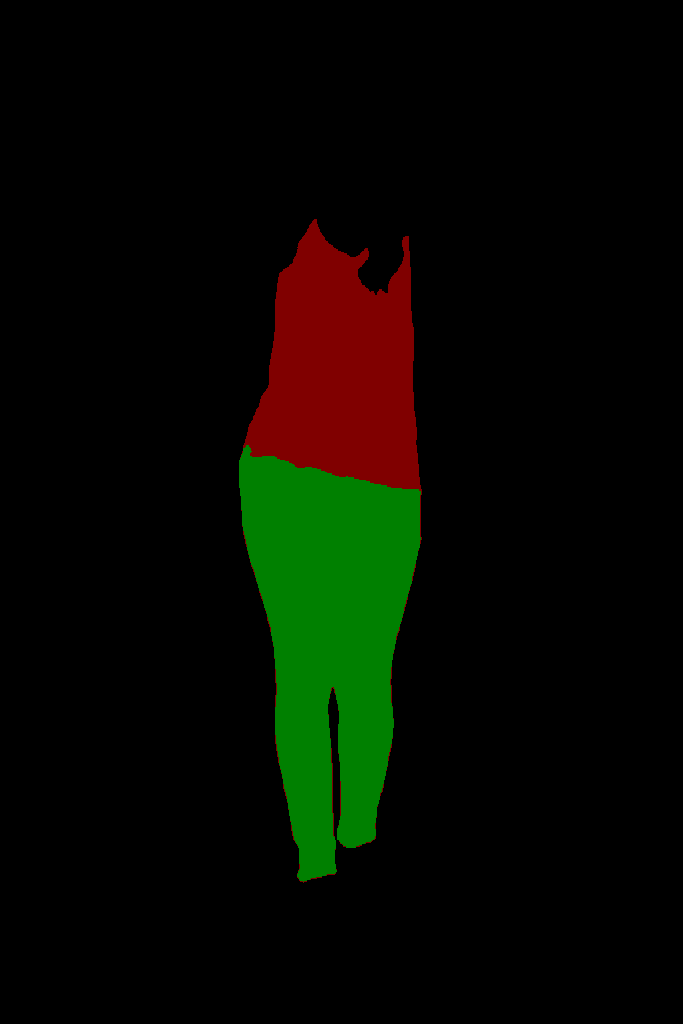

In [39]:
segmented_img

In [44]:
na = np.array(segmented_img.convert('RGB'))
colours, counts = np.unique(na.reshape(-1,3), axis=0, return_counts=1)

In [45]:
colours

array([[  0,   0,   0],
       [  0, 128,   0],
       [128,   0,   0]], dtype=uint8)

In [51]:
segmented_img2 = segmented_img.convert('RGB')
resized_image1 = segmented_img2.resize(stylized.size, Image.ANTIALIAS)
resized_image2 = np.array(resized_image1)
og_img = np.array(img)
stylized2 = np.resize(stylized2, og_img.shape)

In [196]:
seg_styled = resized_image2.copy()
finale = og_img[0,:,:,:].copy()
for i in range(finale.shape[0]):
    for j in range(finale.shape[1]):
        if not np.array_equal(resized_image2[i][j], [0, 0, 0]) and resized_image2[i][j][1]==0:
            seg_styled[i][j] = stylized2[i][j]
            finale[i][j] = stylized2[i][j]/255

In [197]:
seg_styled2 = resized_image2.copy()
finale2 = og_img[0,:,:,:].copy()
for i in range(finale2.shape[0]):
    for j in range(finale2.shape[1]):
        if not np.array_equal(resized_image2[i][j], [0, 0, 0]) and resized_image2[i][j][0]==0:
            seg_styled2[i][j] = stylized2[i][j]
            finale2[i][j] = stylized2[i][j]/255

In [198]:
seg_styled3 = resized_image2.copy()
finale3 = og_img[0,:,:,:].copy()
for i in range(finale3.shape[0]):
    for j in range(finale3.shape[1]):
        if not np.array_equal(resized_image2[i][j], [0, 0, 0]) and resized_image2[i][j][2]==0:
            seg_styled3[i][j] = stylized2[i][j]
            finale3[i][j] = stylized2[i][j]/255

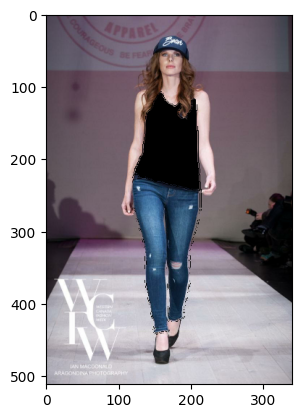

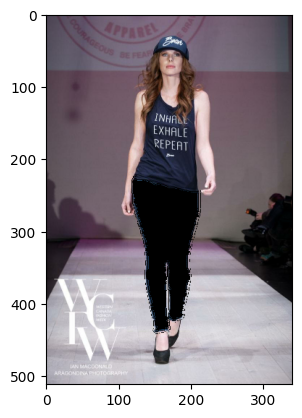

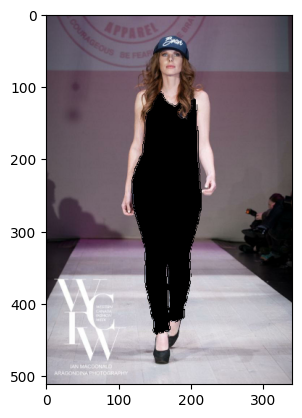

In [199]:
plt.imshow(finale)
plt.show()
plt.imshow(finale2)
plt.show()
plt.imshow(finale3)
plt.show()